In [1]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, SqueezeBertForSequenceClassification, AdamW
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import time

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

train_data = pd.read_csv('issues_train.csv')
test_data = pd.read_csv('issues_test.csv')

# perform pre-processing steps
def preprocess(text):
    if isinstance(text, float):
        return ''   
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [re.sub(r'[^a-zA-Z0-9]', '', token) for token in tokens if re.sub(r'[^a-zA-Z0-9]', '', token) != '']
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    processed_text = ' '.join(tokens)
    return processed_text

train_data['title_processed'] = train_data['title'].apply(preprocess)
train_data['body_processed'] = train_data['body'].apply(preprocess)

test_data['title_processed'] = test_data['title'].apply(preprocess)
test_data['body_processed'] = test_data['body'].apply(preprocess)

# Selecting features and labels
X_train = train_data['title_processed'] + ' ' + train_data['body_processed']
y_train = train_data['label']
X_test = test_data['title_processed'] + ' ' + test_data['body_processed']
y_test = test_data['label']

# Tokenization
tokenizer = AutoTokenizer.from_pretrained('squeezebert/squeezebert-uncased', do_lower_case=True)
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True)

label_map = {label: i for i, label in enumerate(y_train.unique())}
train_labels = [label_map[label] for label in y_train]
test_labels = [label_map[label] for label in y_test]

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))
test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Loading model
model = SqueezeBertForSequenceClassification.from_pretrained('squeezebert/squeezebert-uncased', num_labels=len(label_map)).to('cuda')

# training parameters
batch_size = 16
num_epochs = 25
learning_rate = 2e-5

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)

# optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Training 
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        batch = tuple(t.to('cuda') for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')

training_time = time.time() - start_time


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Some weights of SqueezeBertForSequenceClassification were not initialized from the model checkpoint at squeezebert/squeezebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/25, Loss: 95.33489495515823
Epoch 2/25, Loss: 79.97286605834961
Epoch 3/25, Loss: 65.13656130433083
Epoch 4/25, Loss: 54.19691330194473
Epoch 5/25, Loss: 43.225032314658165
Epoch 6/25, Loss: 36.937337540090084
Epoch 7/25, Loss: 27.770544596016407
Epoch 8/25, Loss: 23.02663830667734
Epoch 9/25, Loss: 14.390334077179432
Epoch 10/25, Loss: 11.043740328401327
Epoch 11/25, Loss: 9.809903874993324
Epoch 12/25, Loss: 10.85811082366854
Epoch 13/25, Loss: 8.320186930708587
Epoch 14/25, Loss: 6.407448710408062
Epoch 15/25, Loss: 8.211243054829538
Epoch 16/25, Loss: 3.912821313366294
Epoch 17/25, Loss: 1.7734574628993869
Epoch 18/25, Loss: 1.7003817015793175
Epoch 19/25, Loss: 2.209114835364744
Epoch 20/25, Loss: 4.283558652736247
Epoch 21/25, Loss: 2.62722578109242
Epoch 22/25, Loss: 1.4453478718642145
Epoch 23/25, Loss: 2.4843763776589185
Epoch 24/25, Loss: 4.414972019381821
Epoch 25/25, Loss: 2.3787534632720053


In [3]:
import numpy as np

def calculate_metrics(labels, preds):
    precision, recall, f1_score, _ = precision_recall_fscore_support(labels, preds, average=None, labels=np.unique(preds))
    avg_precision, avg_recall, avg_f1_score, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return precision, recall, f1_score, avg_precision, avg_recall, avg_f1_score

# Evaluation
model.eval()
all_preds = []
all_labels = []
eval_start_time = time.time()
for batch in test_dataloader:
    batch = tuple(t.to('cuda') for t in batch)  # Move batch to the appropriate device
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
    preds = np.argmax(logits.cpu().numpy(), axis=1)
    all_preds.extend(preds)
    all_labels.extend(batch[2].cpu().numpy())
    
evaluation_time = time.time() - eval_start_time

# Classification report
target_names = list(label_map.keys())
print(classification_report(all_labels, all_preds, target_names=target_names))

              precision    recall  f1-score   support

         bug       0.82      0.71      0.76       500
     feature       0.81      0.77      0.79       500
    question       0.67      0.79      0.72       500

    accuracy                           0.76      1500
   macro avg       0.77      0.76      0.76      1500
weighted avg       0.77      0.76      0.76      1500



In [35]:
from sklearn.metrics import precision_recall_fscore_support

def generate_predictions(model, dataloader):
    model.eval()
    all_preds = []
    for batch in dataloader:
        batch = tuple(t.to('cuda') for t in batch)  # Move batch to the appropriate device
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
        preds = np.argmax(logits.cpu().numpy(), axis=1)
        all_preds.extend(preds)
    return all_preds

test_predictions = generate_predictions(model, test_dataloader)

# Classification Report
repo_metrics = {}
for repo, data in test_data.groupby('repo'):
    repo_labels = data['label'].map(label_map)  
    repo_preds = test_predictions[:len(data)]  
    test_predictions = test_predictions[len(data):]  
    precision, recall, f1_score, support = precision_recall_fscore_support(repo_labels, repo_preds, average=None, labels=np.unique(repo_preds))
    
    if len(precision) < len(label_map):
        precision = np.append(precision, 0)  
        recall = np.append(recall, 0) 
        f1_score = np.append(f1_score, 0)  
    
    avg_precision, avg_recall, avg_f1_score, _ = precision_recall_fscore_support(repo_labels, repo_preds, average='weighted')
    repo_metrics[repo] = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1_score': avg_f1_score
    }

for repo, metrics in repo_metrics.items():
    print(f"\nMetrics for Repository: {repo}")
    print("Precision:", metrics['precision'])
    print("Recall:", metrics['recall'])
    print("F1-score:", metrics['f1_score'])
    print("Average Precision:", metrics['avg_precision'])
    print("Average Recall:", metrics['avg_recall'])
    print("Average F1-score:", metrics['avg_f1_score'])

# Calculate cross-repo average metrics
all_precision = [metrics['precision'] for metrics in repo_metrics.values()]
all_recall = [metrics['recall'] for metrics in repo_metrics.values()]
all_f1_score = [metrics['f1_score'] for metrics in repo_metrics.values()]

cross_repo_avg_precision = np.mean(all_precision, axis=0)
cross_repo_avg_recall = np.mean(all_recall, axis=0)
cross_repo_avg_f1_score = np.mean(all_f1_score, axis=0)

print("\nCross-Repository Average Metrics:")
print("Average Precision:", cross_repo_avg_precision)
print("Average Recall:", cross_repo_avg_recall)
print("Average F1-score:", cross_repo_avg_f1_score)



Metrics for Repository: bitcoin/bitcoin
Precision: [0.04166667 0.01123596 0.2173913 ]
Recall: [0.04 0.01 0.25]
F1-score: [0.04081633 0.01058201 0.23255814]
Average Precision: 0.09009797535689083
Average Recall: 0.1
Average F1-score: 0.09465215888250218

Metrics for Repository: facebook/react
Precision: [0.08421053 0.93902439 0.09756098]
Recall: [0.08 0.77 0.12]
F1-score: [0.08205128 0.84615385 0.10762332]
Average Precision: 0.37359863072314925
Average Recall: 0.3233333333333333
Average F1-score: 0.34527614886359276

Metrics for Repository: microsoft/vscode
Precision: [0.85483871 0.75961538 0.64179104]
Recall: [0.53 0.79 0.86]
F1-score: [0.65432099 0.7745098  0.73504274]
Average Precision: 0.7520817130229744
Average Recall: 0.7266666666666667
Average F1-score: 0.7212911755395415

Metrics for Repository: opencv/opencv
Precision: [0.09756098 0.07216495 0.57024793]
Recall: [0.08 0.07 0.69]
F1-score: [0.08791209 0.07106599 0.62443439]
Average Precision: 0.24665795264922064
Average Recall: 

In [36]:
print(test_data.columns)

Index(['repo', 'created_at', 'label', 'title', 'body', 'title_processed',
       'body_processed'],
      dtype='object')


In [17]:
model.save_pretrained('squeezebert')

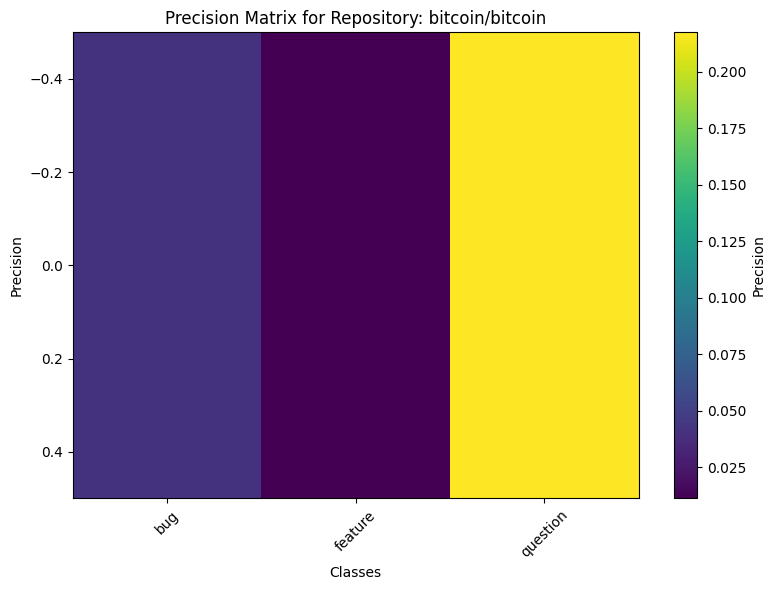

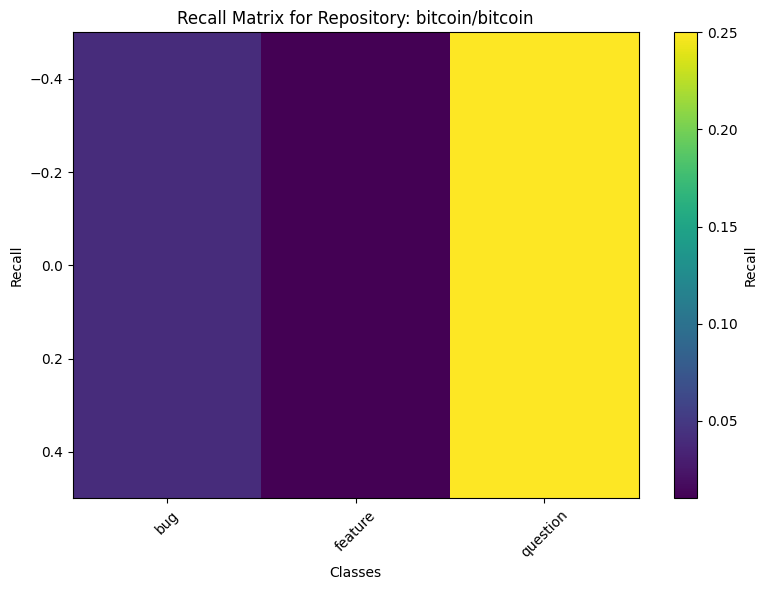

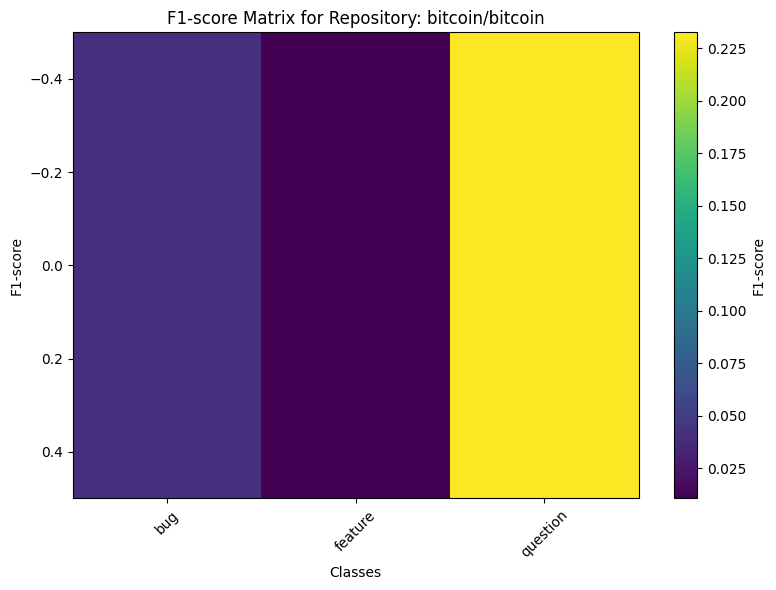

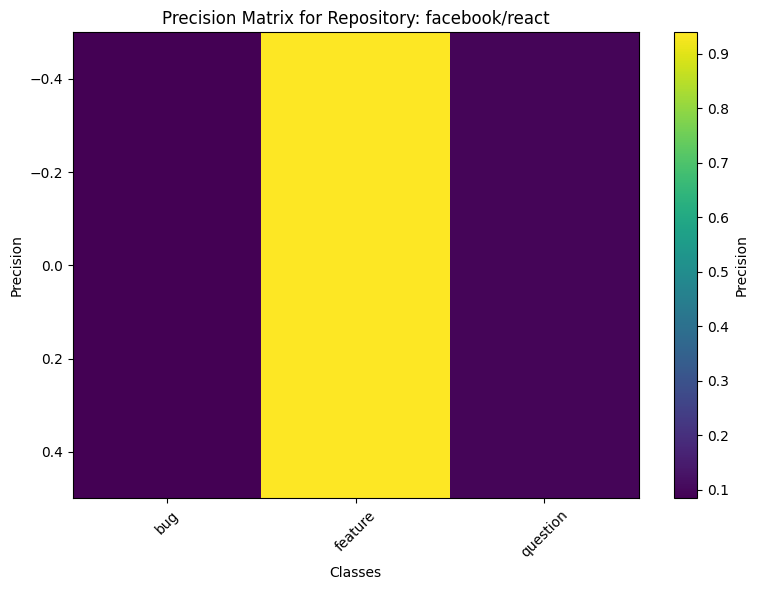

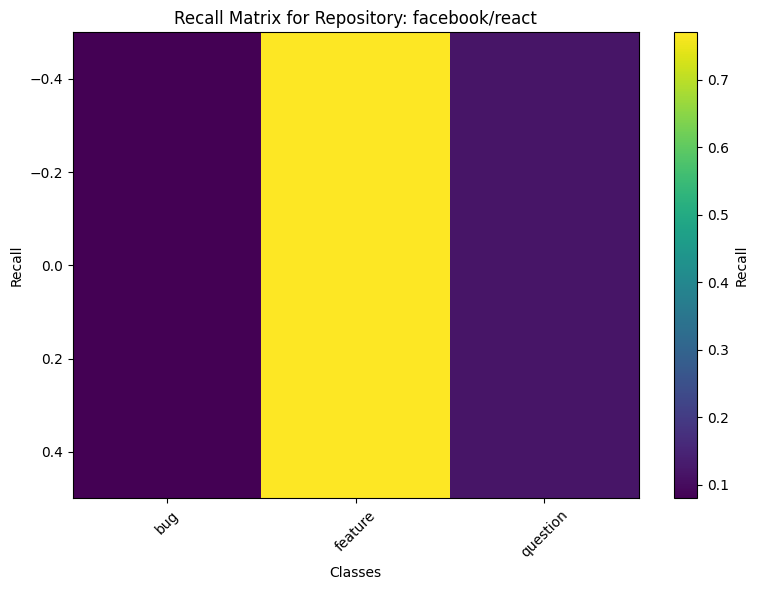

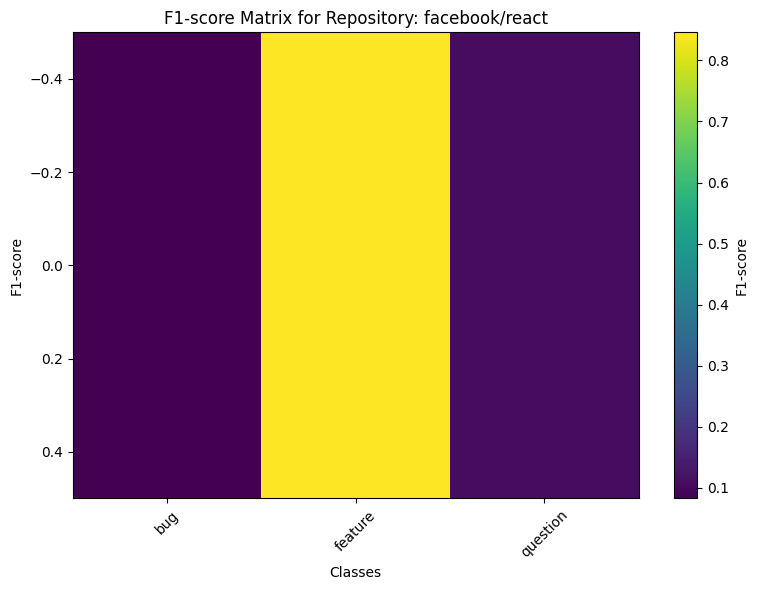

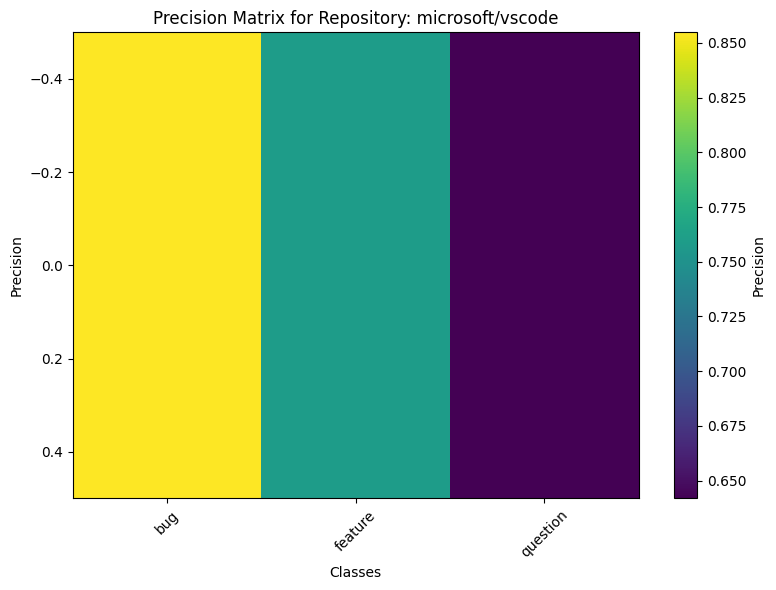

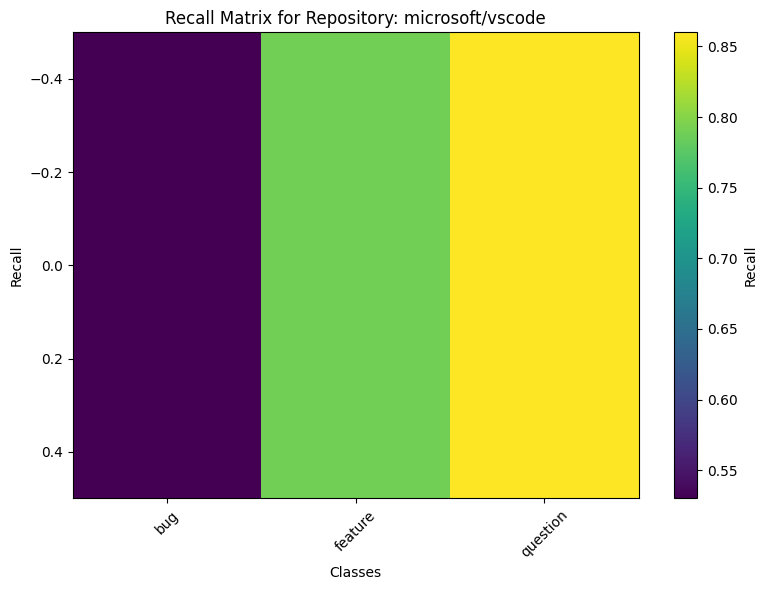

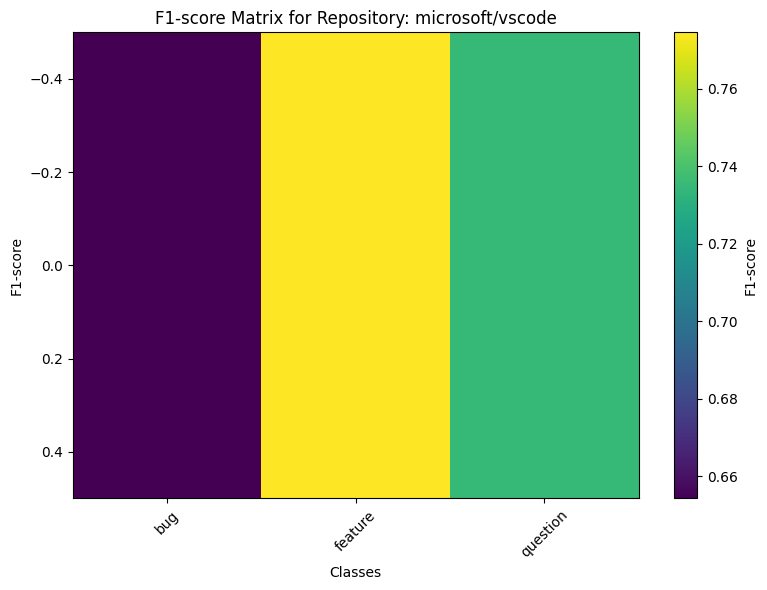

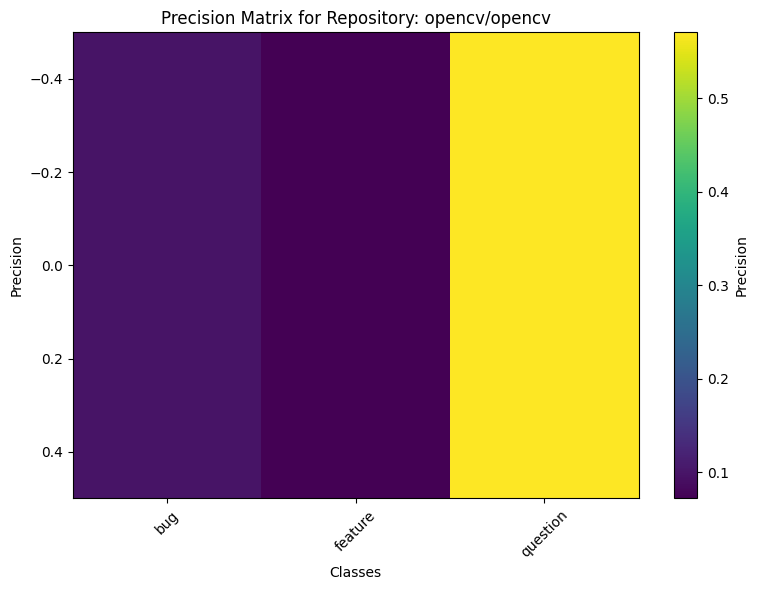

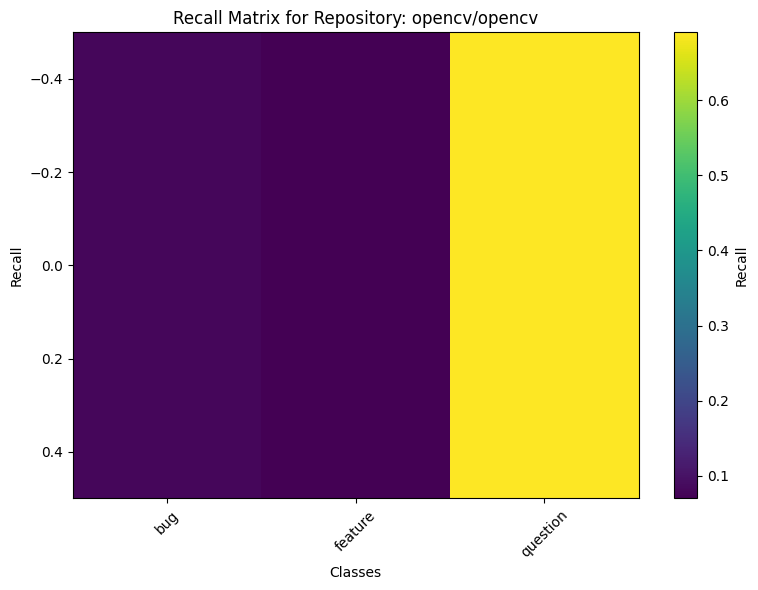

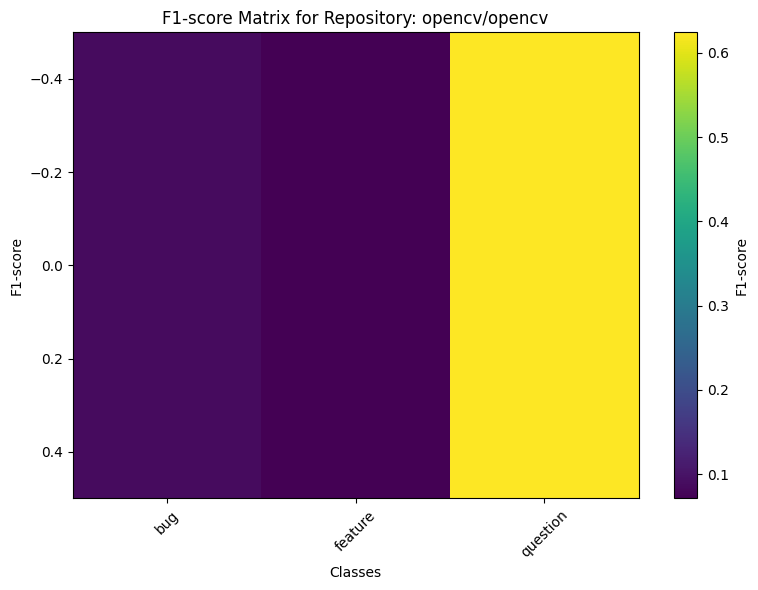

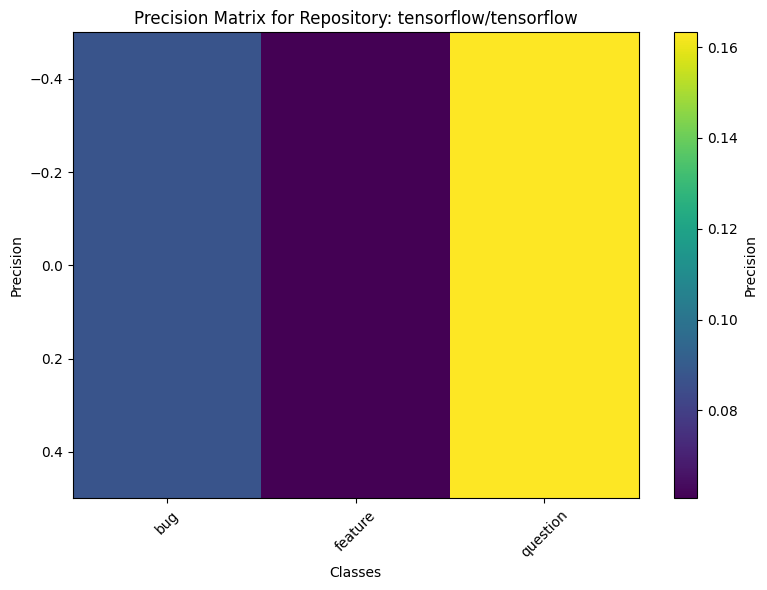

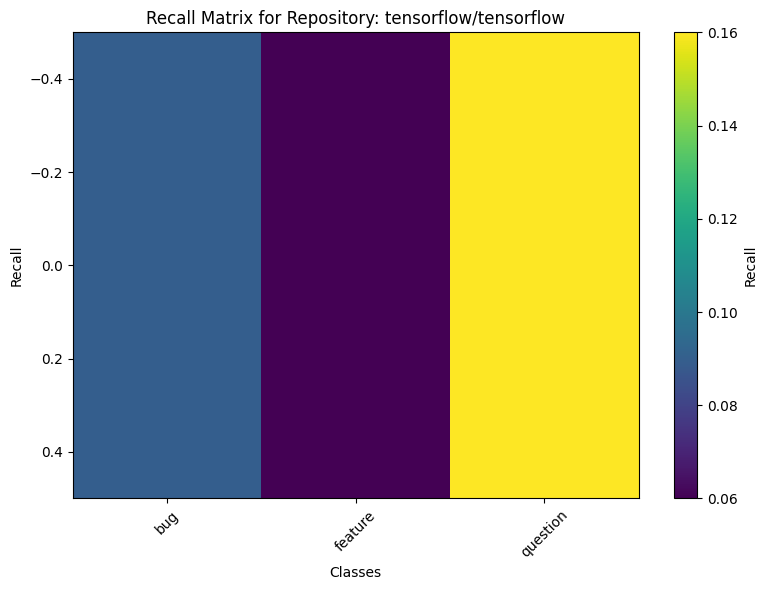

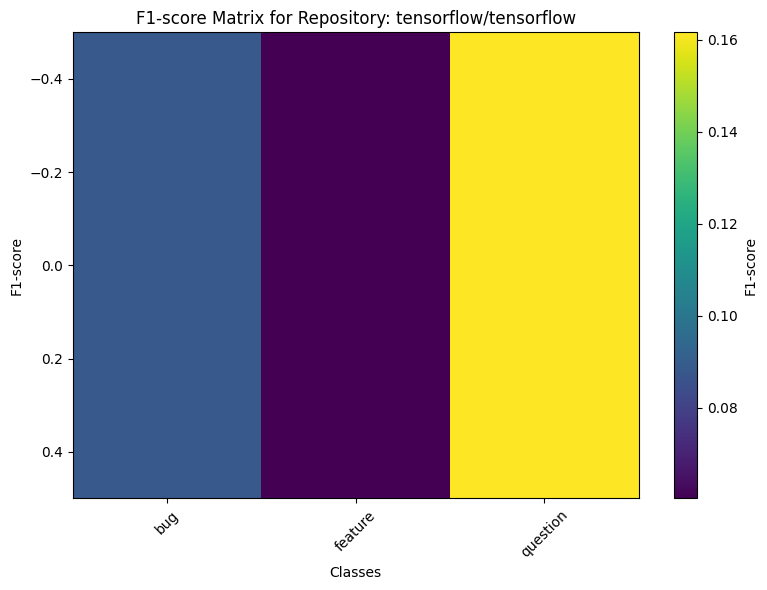

In [37]:
import matplotlib.pyplot as plt

# Plot metrics for each repo
for repo, metrics in repo_metrics.items():
    classes = list(label_map.keys())
    
    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['precision']], cmap='viridis', aspect='auto')
    plt.title(f'Precision Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('Precision')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='Precision')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['recall']], cmap='viridis', aspect='auto')
    plt.title(f'Recall Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='Recall')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.imshow([metrics['f1_score']], cmap='viridis', aspect='auto')
    plt.title(f'F1-score Matrix for Repository: {repo}')
    plt.xlabel('Classes')
    plt.ylabel('F1-score')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.colorbar(label='F1-score')
    plt.tight_layout()
    plt.show()


In [2]:
import torch
from transformers import SqueezeBertForSequenceClassification, AutoTokenizer
import time

model_path = '/home/codegen_inference/squeezebert'
model = SqueezeBertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained('squeezebert/squeezebert-uncased')

In [4]:
input_text = "please provide clear concise description bug include screenshots needed please test using latest version relevant react package make sure issue already fixed react version 1830canary493f72b0a20230727 step reproduce 1 run following code j import reactdomserver reactdomserver const element html head meta title hoisted meta charset utf8 title title title script tag hoisted script src foo script hoisted script src foo async script head html consolelog reactdomserverrendertostring element bug get fixed much faster run code doesnt dependency react issue without reproduction step code example may immediately closed actionable link code example http codesandboxiosreact1830canary493f72b0a20230727ssrhoistbuglvhj45 filesrcindexjs please provide codesandbox http codesandboxiosnew link repository github provide minimal code example reproduces problem may provide screenshot application think relevant bug report tip providing minimal example http stackoverflowcomhelpmcve current behavior consolelog output meta charset utf8 script src foo async script title title title html head script src foo script head html expected behavior consolelog output html head meta charset utf8 title title title script src foo script script src foo async script head html."

inputs = tokenizer(input_text, return_tensors="pt")

start_time = time.time()
with torch.no_grad():
    outputs = model(**inputs)
inference_time = time.time() - start_time

label_map = {0: 'bug', 1: 'feature', 2: 'question'}  

predicted_label_idx = torch.argmax(outputs.logits)
predicted_label = label_map[predicted_label_idx.item()]

print("Predicted Label:", predicted_label)
print("Inference Time:", inference_time, "seconds")


Predicted Label: question
Inference Time: 0.46573352813720703 seconds
